## Projection Persuit + Extreme Value Theory
Calculate the probability by summing over the kde above the point.

H0 bootstrapping: Lx-T 8.7, 2.8sigma; Ysz-T 14.0, 4.1sigma

H0 mcmc: Lx-T 8.7, 2.4sigma; Ysz-T 14.0, 2.6sigma

Prob of obtaining (DH%, nsigma)= [8.7 2.4] in $L_\mathrm{{X}}-T$.
KDE peak (mode): [3.0844228845382666, 1.431725951117964]
Number of sigma deviations: 4.637332652255458
EVT-based p-value: 0.26431609278932844


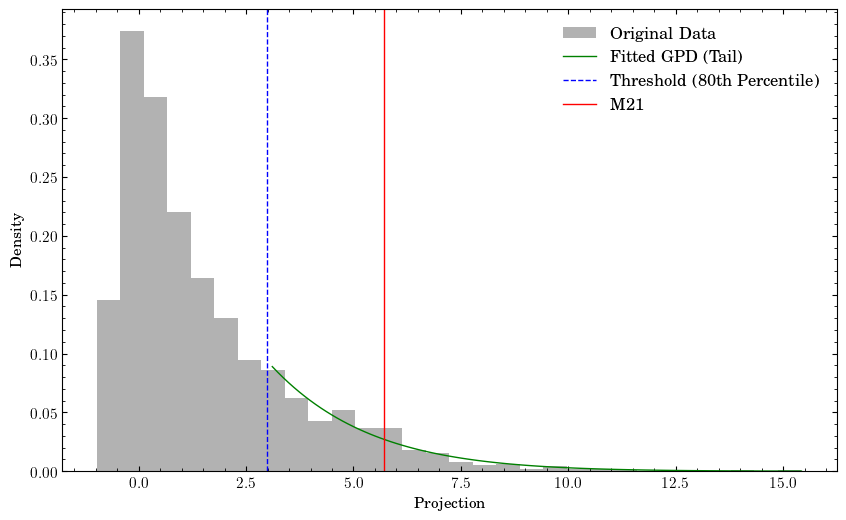

Prob of obtaining (DH%, nsigma)= [14.   2.6] in $Y_\mathrm{{SZ}}-T$.
KDE peak (mode): [2.110063583689919, 1.4214719713024129]
Number of sigma deviations: 15.205814074711148
EVT-based p-value: 0.0002369448564852883


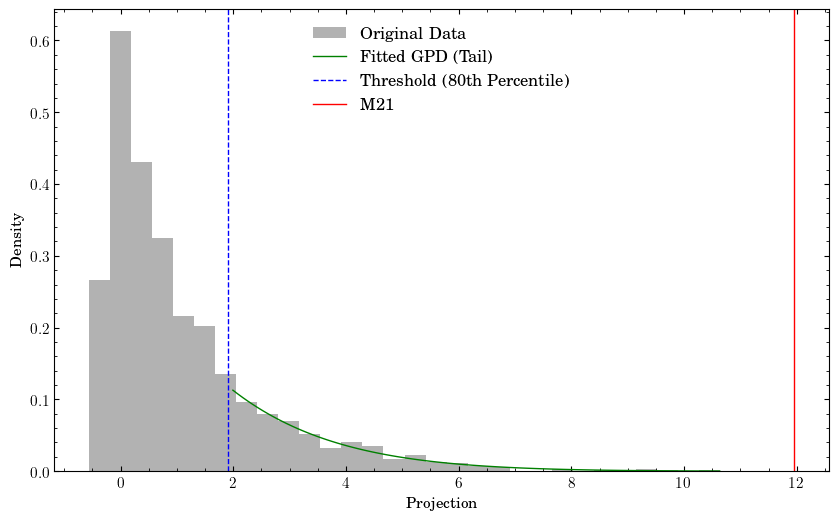

In [ ]:
# mcmc method
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

data = pd.read_csv('/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_mc_all.csv')

target_point_arr = [np.array([8.7, 2.4]), np.array([14, 2.6])]
for relation, target_point in zip(['$L_\mathrm{{X}}-T$', '$Y_\mathrm{{SZ}}-T$'],
                                  target_point_arr):

    print(f'Prob of obtaining (DH%, nsigma)= {target_point} in {relation}.')    

    # Load the data
    df = data[data['Relations'] == relation]

    # Extract the data
    data_array = df[['$\Delta H_0\,(\%)$', 'Significance $(\sigma)$']].values.T

    # Fit the KDE
    kde = gaussian_kde(data_array)

    # Create a grid for evaluation
    x_min, x_max = data_array[0].min(), data_array[0].max()
    y_min, y_max = data_array[1].min(), data_array[1].max()
    x_grid, y_grid = np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

    # Evaluate the KDE on the grid
    positions = np.vstack([x_mesh.ravel(), y_mesh.ravel()])
    kde_values = kde(positions).reshape(x_mesh.shape)

    # Find the grid point with the maximum KDE value (KDE peak)
    max_idx = np.unravel_index(np.argmax(kde_values), kde_values.shape)
    kde_peak = [x_grid[max_idx[1]], y_grid[max_idx[0]]]
    print(f"KDE peak (mode): {kde_peak}")




    # Compute the direction vector from the KDE peak to the target point
    direction_vector = target_point - kde_peak
    direction_vector /= np.linalg.norm(direction_vector)  # Normalize the direction vector

    # Project all data points onto the direction vector
    data_points = df[['$\Delta H_0\,(\%)$', 'Significance $(\sigma)$']].values
    projections = np.dot(data_points - kde_peak, direction_vector)



    # Center the projections so that the KDE peak corresponds to zero
    # (Already centered since we subtracted kde_peak)

    # Project the target point onto the direction vector
    target_projection = np.dot(target_point - kde_peak, direction_vector)

    # Compute the standard deviation using the +34th percentile from the KDE peak
    kde_peak_percentile = np.sum(projections <= 0) / len(projections) * 100
    std_proj = np.percentile(projections, kde_peak_percentile + 34)

    # Note: Since the KDE peak is at zero, the 50th percentile of the projections is approximately zero

    # Compute the number of sigma deviations for the target point
    sigma_deviation = (target_projection) / std_proj
    print(f"Number of sigma deviations: {sigma_deviation}")




    import matplotlib.pyplot as plt
    plt.style.use('./nice.mplstyle')
    from scipy.stats import genpareto


    # Set a high threshold (e.g., 95th percentile)
    percentile = 80
    threshold = np.percentile(projections, percentile)
    exceedances = projections[projections > threshold] - threshold  # Calculate excesses over the threshold

    # Fit the Generalized Pareto Distribution (GPD)
    params = genpareto.fit(exceedances)
    shape, loc, scale = params

    # Compute exceedance probability of the target projection
    if target_projection > threshold:
        p_value_evt = 1 - genpareto.cdf(target_projection - threshold, *params)
    else:
        p_value_evt = 1.0  # Target point not in tail
    print(f"EVT-based p-value: {p_value_evt}")

    # Visualization
    plt.figure(figsize=(10, 6))

    # Plot histogram of the entire projections
    plt.hist(projections, bins=30, density=True, alpha=0.6, color='gray', label='Original Data')

    # Plot fitted GPD for the tail
    x_vals = np.linspace(threshold, projections.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile/100)
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')

    # Mark threshold
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')

    # Mark the target projection
    plt.axvline(target_projection, color='red', linestyle='-', label=f'M21')

    # Add labels and legend
    plt.xlabel('Projection')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Prob of obtaining (DH%, nsigma)= [8.7 2.6] in $L_\mathrm{{X}}-T$.
KDE peak (mode): [3.8697310449360858, 1.4910826285922265]
Number of sigma deviations: 3.392883794755132
EVT-based p-value: 0.03400226125317862


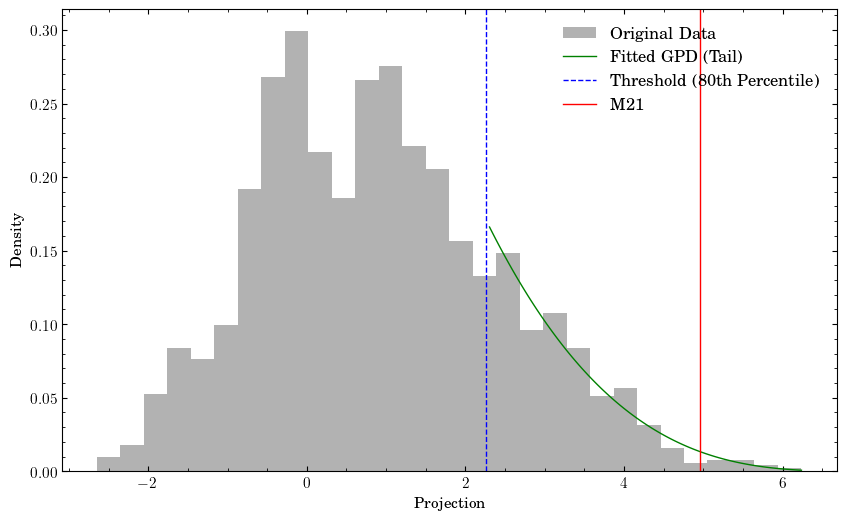

Prob of obtaining (DH%, nsigma)= [14.   4.1] in $Y_\mathrm{{SZ}}-T$.
KDE peak (mode): [3.7483464789506113, 0.2232116880042149]
Number of sigma deviations: 4.829226609939176
EVT-based p-value: 0.42845387115510447


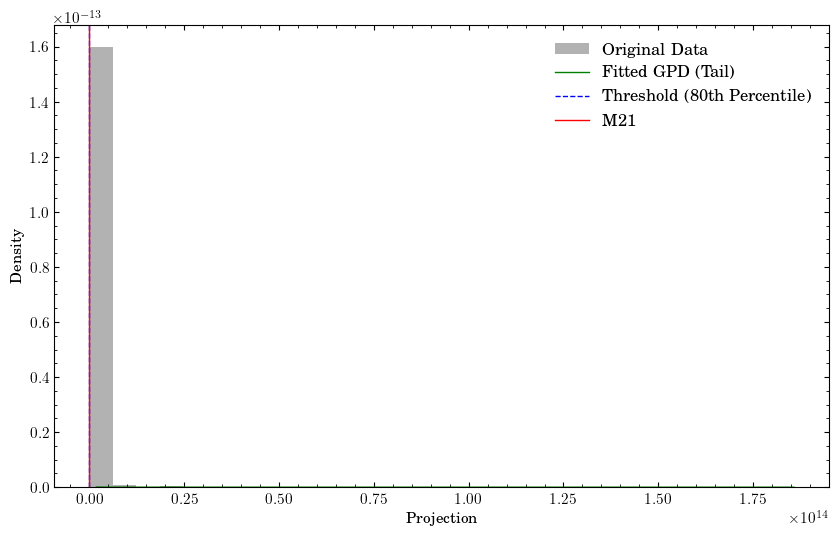

In [ ]:
# chi2 method
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

data = pd.read_csv('/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_direct_compare.csv')
data['Delta_H0'] *= 100

target_point_arr = [np.array([8.7, 2.6]), np.array([14, 4.1])]
for relation, target_point in zip(['$L_\mathrm{{X}}-T$', '$Y_\mathrm{{SZ}}-T$'],
                                  target_point_arr):

    print(f'Prob of obtaining (DH%, nsigma)= {target_point} in {relation}.')    

    # Load the data
    df = data[data['Relations'] == relation]

    # Extract the data
    data_array = df[['Delta_H0', 'Significance']].values.T

    # Fit the KDE
    kde = gaussian_kde(data_array)

    # Create a grid for evaluation
    x_min, x_max = data_array[0].min(), data_array[0].max()
    y_min, y_max = data_array[1].min(), data_array[1].max()
    x_grid, y_grid = np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

    # Evaluate the KDE on the grid
    positions = np.vstack([x_mesh.ravel(), y_mesh.ravel()])
    kde_values = kde(positions).reshape(x_mesh.shape)

    # Find the grid point with the maximum KDE value (KDE peak)
    max_idx = np.unravel_index(np.argmax(kde_values), kde_values.shape)
    kde_peak = [x_grid[max_idx[1]], y_grid[max_idx[0]]]
    print(f"KDE peak (mode): {kde_peak}")




    # Compute the direction vector from the KDE peak to the target point
    direction_vector = target_point - kde_peak
    direction_vector /= np.linalg.norm(direction_vector)  # Normalize the direction vector

    # Project all data points onto the direction vector
    data_points = df[['Delta_H0', 'Significance']].values
    projections = np.dot(data_points - kde_peak, direction_vector)



    # Center the projections so that the KDE peak corresponds to zero
    # (Already centered since we subtracted kde_peak)

    # Project the target point onto the direction vector
    target_projection = np.dot(target_point - kde_peak, direction_vector)

    # Compute the standard deviation using the +34th percentile from the KDE peak
    kde_peak_percentile = np.sum(projections <= 0) / len(projections) * 100
    std_proj = np.percentile(projections, kde_peak_percentile + 34)

    # Note: Since the KDE peak is at zero, the 50th percentile of the projections is approximately zero

    # Compute the number of sigma deviations for the target point
    sigma_deviation = (target_projection) / std_proj
    print(f"Number of sigma deviations: {sigma_deviation}")




    import matplotlib.pyplot as plt
    plt.style.use('./nice.mplstyle')
    from scipy.stats import genpareto


    # Set a high threshold (e.g., 95th percentile)
    percentile = 80
    threshold = np.percentile(projections, percentile)
    exceedances = projections[projections > threshold] - threshold  # Calculate excesses over the threshold

    # Fit the Generalized Pareto Distribution (GPD)
    params = genpareto.fit(exceedances)
    shape, loc, scale = params

    # Compute exceedance probability of the target projection
    if target_projection > threshold:
        p_value_evt = 1 - genpareto.cdf(target_projection - threshold, *params)
    else:
        p_value_evt = 1.0  # Target point not in tail
    print(f"EVT-based p-value: {p_value_evt}")

    # Visualization
    plt.figure(figsize=(10, 6))

    # Plot histogram of the entire projections
    plt.hist(projections, bins=30, density=True, alpha=0.6, color='gray', label='Original Data')

    # Plot fitted GPD for the tail
    x_vals = np.linspace(threshold, projections.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile/100)
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')

    # Mark threshold
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')

    # Mark the target projection
    plt.axvline(target_projection, color='red', linestyle='-', label=f'M21')

    # Add labels and legend
    plt.xlabel('Projection')
    plt.ylabel('Density')
    plt.legend()
    plt.show()